# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
from dqn_agent import DQNAgent
from replay_buffer import UniformReplayBufferFactory, PrioritizedReplayBufferFactory
from q_net  import QFCNetFactory

import inspect

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
import platform
import os

# Checking platform/machine
print('Current platform: {}-{}'.format(platform.system(), platform.machine()))
unity_env_folder = 'unity_envs'
env_name = 'BananaCollector'
# Since I am switching between platforms
unity_env_file_name = {'Linux-x86_64': os.path.join(unity_env_folder, env_name, 'Banana_Linux', 'Banana.x86_64'),
                       'Darwin-x86_64': os.path.join(unity_env_folder, env_name, 'Banana_Darwin', 'Banana.app')}['{}-{}'.format(platform.system(), platform.machine())]

Current platform: Linux-x86_64


In [3]:
env = UnityEnvironment(file_name=unity_env_file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 4.DQN Exploration

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.
The architecture explored  to solve the vector observation environment is a fully connected network with 2 hidden layer with 64 node each. Each of the hidden layer is followed by a non linear activation (`Relu` activation), as we can remark in the default architecture built via the factory (see code below).

In [6]:
from q_net  import QFCNet
print(inspect.getsource(QFCNet.__init__))

def __init__(self, state_size: int, action_size: int, layers: Tuple[int], seed: int = 0):
        """Initialize parameters and build model.

        :param state_size: Dimension of each state
        :param action_size: Dimension of each action
        :param seed: Random seed
        :param layers: FC layers defined by their size (neurones number)
        """
        super(QFCNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layers_dim = [state_size] + list(layers) + [action_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_layer, out_layer) for in_layer, out_layer in
             zip(self.layers_dim, self.layers_dim[1:])])



In [7]:
def ma(scores, window):
    """ Moving average helper (for result plotting)"""
    tmp = np.cumsum(scores)
    return (tmp[window:] - tmp[:-window])/window

In [8]:
def plot_scores(agents, episodes_window=100):
    """ A helper to plot scores."""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for agent in agents:
        scores = ma (agent.scores, episodes_window)
        plt.plot(np.arange(episodes_window, episodes_window + len(scores)), scores, label=agent.name) 

    plt.yticks (range(14))
    plt.ylabel('Score av. window [{}]'.format(episodes_window))
    plt.xlabel('Episode #')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def extract_state(env_info) -> np.ndarray:
    """ state extractor: extracts state representation from env_info"""
    return env_info.vector_observations[0]


In [10]:
# Defines a factory that builds a default FCN (64, Relu, 64, Relu, action_size) as described before
# used for the base_line as seems to work well
# (will explore more architecture after Refactoring the Pytorch Netork builder)

net_factory = QFCNetFactory(state_size, action_size)

### The Base line (as a succeful solver)

In [11]:
replay_buffer_factory = UniformReplayBufferFactory()
the_base_line_solver = DQNAgent(net_factory, replay_buffer_factory, seed=0,  batch_size=64, step_to_update= 5, 
                                buffer_size=int(1e5), gamma=.99, lr=5e-4, tau=1e-3, episodes_window_size=100,
                                name='the solver')
the_base_line_solver.explore(env, extract_state, n_episodes=600)

INFO:root:Building replay buffer with size 100000
Episode 100	Average Score: 0.71
Episode 200	Average Score: 2.56
Episode 300	Average Score: 6.17
Episode 400	Average Score: 9.48
Episode 479	Average Score: 13.05
Environment solved in 379 episodes!	Average Score: 13.05


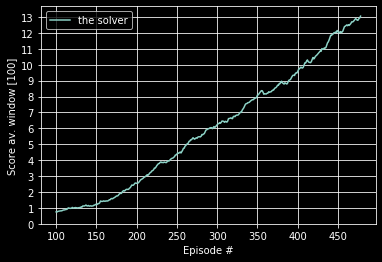

In [12]:
plot_scores([the_base_line_solver])

### Exprimenting with faster (not that soft) update (higher tau.) should be less stable

In this section the network hyperparameter were kept the same while the target Q is updated faster so the name `the_jumpy`

In [13]:
replay_buffer_factory = UniformReplayBufferFactory()
the_jumpy = DQNAgent(net_factory, replay_buffer_factory, seed=0,  batch_size=64, step_to_update= 5,
                   buffer_size=int(1e5), gamma=.99, lr=5e-4, tau=1e-1, episodes_window_size=100, name='the jumpy')
the_jumpy.explore(env, extract_state, n_episodes=600) # as we solved the env in less than 500 episodes

INFO:root:Building replay buffer with size 100000
Episode 100	Average Score: 1.93
Episode 200	Average Score: 6.23
Episode 300	Average Score: 9.32
Episode 400	Average Score: 9.55
Episode 500	Average Score: 12.11
Episode 577	Average Score: 13.05
Environment solved in 477 episodes!	Average Score: 13.05


### A simple stoch. prioritization

This section is about testing a simple priority mechanism. At each training/learn step while giving an increasing chance (throughout the process) to experiences with higher error to conduct the training (training to reduce these errors). Thus we called our agent here `error_smasher`.



In [14]:
from replay_buffer  import  PrioritizedReplayBuffer
print(inspect.getsource(PrioritizedReplayBuffer.sample))

def sample(self):
        """Randomly sample a batch of experiences from memory."""
        highest_error_experience = nsmallest(self.batch_size, self.memory, key=lambda item: item.error)
        uniform_random_sample = random.sample(self.memory, k=self.batch_size)
        experiences = [
            uniform_random_sample[index] if random.random() < self.alpha else
            heappop(highest_error_experience) for index in range(self.batch_size)]
        # update alpha
        self.alpha = max(self.alpha * self.decay, self.min_alpha)
        return experiences



In [15]:
greedy_high_error = PrioritizedReplayBufferFactory()
error_smasher = DQNAgent(net_factory, greedy_high_error,  seed=0, buffer_size=int(1e5), batch_size=64, name='stoch. prioritized')
error_smasher.explore(env, extract_state, n_episodes=600)

INFO:root:Building replay buffer with size 100000
Episode 100	Average Score: 0.65
Episode 200	Average Score: 4.72
Episode 300	Average Score: 8.78
Episode 400	Average Score: 11.00
Episode 481	Average Score: 13.03
Environment solved in 381 episodes!	Average Score: 13.03


## Comparing all the agents

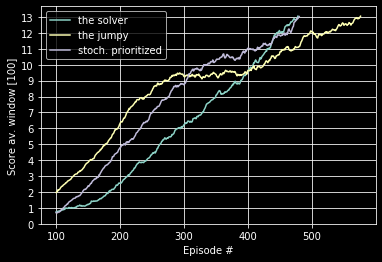

In [16]:
plot_scores([the_base_line_solver, the_jumpy, error_smasher])

## Closing the environement

When finished, you can close the environment.

In [17]:
env.close()

## Future Exploration 

### Experimenting with deeper architectures

### Add/Support Dueling Network Architectures

## Pixels Visual Observation as state

I already started exprimenting with a convolutional DQN with the visual environment. The experiments conducted for now shows a low perf. compared to the vector observation which consumes a better digested and cleaner input. 

### Issue to solve.
Also I need to check the a Unity/python memory leakage problem (I have in the current code version) to run with more episodes.

### Specifically

Include more frames might also help deciding which way to explore before starting collecting the bananas.

